In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import torchvision
import torchvision.transforms.v2 as v2
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

import warnings

warnings.simplefilter("ignore")

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
EPOCHS = 75
PATIENCE = 10
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.0001

In [3]:
def augmentation(img):
    aug = v2.TrivialAugmentWide()    
    
    return aug(img)

def preprocessing(img):
    img = img/255.0
    
    pre = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    return pre(img)

def train_transform(img):
    img = preprocessing(img)
    img = augmentation(img)
        
    return img

def create_dataset(file_dir):
    dataset = {}
    dataset["train"] = ImageFolder(
        root = f"{file_dir}/train/",
        loader = torchvision.io.read_image,
        transform=train_transform
    )
    dataset["val"] = ImageFolder(
        root = f"{file_dir}/val/",
        loader = torchvision.io.read_image,
        transform=preprocessing
    )
    dataset["test"] = ImageFolder(
        root = f"{file_dir}/test/",
        loader = torchvision.io.read_image,
        transform=preprocessing
    )
    
    return dataset
    
dataset = create_dataset("./datasets")

In [4]:
dataloader = dict()
dataloader["train"] = DataLoader(dataset["train"], batch_size=32, shuffle=True)
dataloader["val"] = DataLoader(dataset["val"], batch_size=32, shuffle=True)
dataloader["test"] = DataLoader(dataset["test"], batch_size=32, shuffle=False)
print("Length of train dataloader: ", len(dataloader["train"]))
print("Length of val dataloader: ", len(dataloader["val"]))
print("Length of test dataloader: ", len(dataloader["test"]))

Length of train dataloader:  955
Length of val dataloader:  97
Length of test dataloader:  97


In [5]:
import torch.nn as nn
import copy

class JointModel(nn.Module):
    def __init__(self, model):
        super().__init__()

        self.name = model

        model = torchvision.models.get_model(model, weights="DEFAULT")

        self.m = copy.deepcopy(model)

        self.ffnn = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(),
        )

        self.classifier = nn.Linear(512, 5)

    def forward(self, x):
        x = self.m(x)
    
        ret = self.ffnn(x)
        ret = self.classifier(ret)

        return ret

models = [
    JointModel(model="shufflenet_v2_x2_0"),
    JointModel(model="convnext_tiny"),
    JointModel(model="efficientnet_v2_s"),
]

for i in range(len(models)):
    models[i] = models[i].to(device)

In [6]:
from sklearn import metrics

def validation(model, validloader, criterion):
    model.eval()
    actual = []
    prediction = []
    
    with torch.no_grad():
        for images, labels in tqdm(validloader):
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            actual.append(labels)
            prediction.append(output.max(dim=1)[1])
            
    actual = torch.concat(actual).cpu()
    prediction = torch.concat(prediction).cpu()
    
    val_accuracy = metrics.accuracy_score(actual, prediction)
    val_recall = metrics.recall_score(actual, prediction, average='macro')

    return val_accuracy, val_recall

In [7]:
def train(model, trainloader, validloader, optimizer, criterion, num_epochs, patience, save_loc):
    all_train_loss, all_train_accuracy, all_val_accuracy, all_val_recall = [], [], [], []

    num_since_best = 0

    best_accuracy = 0
    
    for epoch in range(num_epochs):

        model.train()

        train_loss = 0
        train_accuracy = 0

        for images, labels in tqdm(trainloader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_accuracy += (
                (labels.data == outputs.max(dim=1)[1]).type(torch.FloatTensor).mean()
            )

        train_loss /= len(trainloader)
        train_accuracy /= len(trainloader)

        val_accuracy, val_recall = validation(model, validloader, criterion)

        print(
            f"Epoch {epoch+1}/{num_epochs}... ",
            f"Train loss: {train_loss:.5f}... ",
            f"Train accuracy: {train_accuracy:.5f}... ",
            f"Validation accuracy: {val_accuracy:.5f}... ",
            f"Validation recall: {val_recall:.5f}... ",
        )

        if epoch == 0 or best_accuracy < val_accuracy:
            torch.save(model.state_dict(), save_loc)
            best_accuracy = val_accuracy
            print("New best model found")
            num_since_best = 0
        else:
            num_since_best += 1

        if num_since_best >= patience:
            break

        all_train_loss.append(train_loss)
        all_train_accuracy.append(train_accuracy)
        all_val_accuracy.append(val_accuracy)
        all_val_recall.append(val_recall)

    return all_train_loss, all_train_accuracy, all_val_accuracy, all_val_recall

In [8]:
for i in range(len(models)):
    print(models[i].name)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(models[i].parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    train_loss, train_accuracy, val_accuracy, val_recall = train(
        models[i], dataloader["train"], dataloader["val"], optimizer, criterion, EPOCHS, PATIENCE, f"./save_models/{models[i].name}.pt"
    )

shufflenet_v2_x2_0


100%|██████████| 97/97 [00:10<00:00,  9.46it/s]


Epoch 1/75...  Train loss: 0.91529...  Train accuracy: 0.63821...  Validation accuracy: 0.75567...  Validation recall: 0.62051... 
New best model found


100%|██████████| 97/97 [00:09<00:00, 10.34it/s]


Epoch 2/75...  Train loss: 0.71977...  Train accuracy: 0.72005...  Validation accuracy: 0.78386...  Validation recall: 0.68368... 
New best model found


100%|██████████| 97/97 [00:10<00:00,  9.56it/s]


Epoch 3/75...  Train loss: 0.60907...  Train accuracy: 0.76472...  Validation accuracy: 0.79391...  Validation recall: 0.68422... 
New best model found


100%|██████████| 97/97 [00:09<00:00, 10.10it/s]


Epoch 4/75...  Train loss: 0.53657...  Train accuracy: 0.79345...  Validation accuracy: 0.80719...  Validation recall: 0.71412... 
New best model found


100%|██████████| 97/97 [00:09<00:00, 10.04it/s]


Epoch 5/75...  Train loss: 0.47330...  Train accuracy: 0.81992...  Validation accuracy: 0.80881...  Validation recall: 0.67101... 
New best model found


100%|██████████| 97/97 [00:09<00:00,  9.79it/s]


Epoch 6/75...  Train loss: 0.42972...  Train accuracy: 0.83491...  Validation accuracy: 0.81335...  Validation recall: 0.70071... 
New best model found


100%|██████████| 97/97 [00:09<00:00, 10.26it/s]


Epoch 7/75...  Train loss: 0.39964...  Train accuracy: 0.84813...  Validation accuracy: 0.81951...  Validation recall: 0.71588... 
New best model found


100%|██████████| 97/97 [00:09<00:00, 10.27it/s]


Epoch 8/75...  Train loss: 0.36432...  Train accuracy: 0.86230...  Validation accuracy: 0.83020...  Validation recall: 0.71815... 
New best model found


100%|██████████| 97/97 [00:10<00:00,  9.34it/s]


Epoch 9/75...  Train loss: 0.34188...  Train accuracy: 0.87009...  Validation accuracy: 0.82404...  Validation recall: 0.72097... 


100%|██████████| 97/97 [00:09<00:00, 10.30it/s]


Epoch 10/75...  Train loss: 0.31759...  Train accuracy: 0.88020...  Validation accuracy: 0.83539...  Validation recall: 0.74014... 
New best model found


100%|██████████| 97/97 [00:10<00:00,  9.69it/s]


Epoch 11/75...  Train loss: 0.29810...  Train accuracy: 0.88694...  Validation accuracy: 0.84219...  Validation recall: 0.73595... 
New best model found


100%|██████████| 97/97 [00:09<00:00, 10.59it/s]


Epoch 12/75...  Train loss: 0.28393...  Train accuracy: 0.89329...  Validation accuracy: 0.81918...  Validation recall: 0.71034... 


100%|██████████| 97/97 [00:09<00:00, 10.39it/s]


Epoch 13/75...  Train loss: 0.27740...  Train accuracy: 0.89708...  Validation accuracy: 0.84608...  Validation recall: 0.77110... 
New best model found


100%|██████████| 97/97 [00:09<00:00, 10.21it/s]


Epoch 14/75...  Train loss: 0.25792...  Train accuracy: 0.90481...  Validation accuracy: 0.84413...  Validation recall: 0.73649... 


100%|██████████| 97/97 [00:09<00:00, 10.72it/s]


Epoch 15/75...  Train loss: 0.24912...  Train accuracy: 0.90831...  Validation accuracy: 0.84446...  Validation recall: 0.73782... 


100%|██████████| 97/97 [00:09<00:00, 10.74it/s]


Epoch 16/75...  Train loss: 0.23355...  Train accuracy: 0.91299...  Validation accuracy: 0.84705...  Validation recall: 0.71590... 
New best model found


100%|██████████| 97/97 [00:09<00:00, 10.03it/s]


Epoch 17/75...  Train loss: 0.22237...  Train accuracy: 0.91845...  Validation accuracy: 0.84122...  Validation recall: 0.74067... 


100%|██████████| 97/97 [00:09<00:00,  9.83it/s]


Epoch 18/75...  Train loss: 0.21749...  Train accuracy: 0.92081...  Validation accuracy: 0.84640...  Validation recall: 0.72049... 


100%|██████████| 97/97 [00:09<00:00, 10.04it/s]


Epoch 19/75...  Train loss: 0.21170...  Train accuracy: 0.92189...  Validation accuracy: 0.84187...  Validation recall: 0.75903... 


100%|██████████| 97/97 [00:08<00:00, 10.99it/s]


Epoch 20/75...  Train loss: 0.19978...  Train accuracy: 0.92853...  Validation accuracy: 0.84154...  Validation recall: 0.73815... 


100%|██████████| 97/97 [00:09<00:00, 10.13it/s]


Epoch 21/75...  Train loss: 0.19688...  Train accuracy: 0.92824...  Validation accuracy: 0.85191...  Validation recall: 0.74489... 
New best model found


100%|██████████| 97/97 [00:09<00:00,  9.83it/s]


Epoch 22/75...  Train loss: 0.19528...  Train accuracy: 0.92896...  Validation accuracy: 0.84608...  Validation recall: 0.75603... 


100%|██████████| 97/97 [00:09<00:00, 10.52it/s]


Epoch 23/75...  Train loss: 0.18508...  Train accuracy: 0.93194...  Validation accuracy: 0.84738...  Validation recall: 0.73454... 


100%|██████████| 97/97 [00:09<00:00, 10.62it/s]


Epoch 24/75...  Train loss: 0.17895...  Train accuracy: 0.93494...  Validation accuracy: 0.83571...  Validation recall: 0.75243... 


100%|██████████| 97/97 [00:09<00:00, 10.49it/s]


Epoch 25/75...  Train loss: 0.17871...  Train accuracy: 0.93452...  Validation accuracy: 0.84997...  Validation recall: 0.73428... 


100%|██████████| 97/97 [00:09<00:00, 10.43it/s]


Epoch 26/75...  Train loss: 0.17214...  Train accuracy: 0.93763...  Validation accuracy: 0.84867...  Validation recall: 0.74627... 


100%|██████████| 97/97 [00:09<00:00, 10.50it/s]


Epoch 27/75...  Train loss: 0.16731...  Train accuracy: 0.93799...  Validation accuracy: 0.84316...  Validation recall: 0.75485... 


100%|██████████| 97/97 [00:09<00:00, 10.56it/s]


Epoch 28/75...  Train loss: 0.16721...  Train accuracy: 0.93858...  Validation accuracy: 0.84802...  Validation recall: 0.75298... 


100%|██████████| 97/97 [00:09<00:00,  9.84it/s]


Epoch 29/75...  Train loss: 0.15993...  Train accuracy: 0.94215...  Validation accuracy: 0.85321...  Validation recall: 0.75186... 
New best model found


100%|██████████| 97/97 [00:09<00:00, 10.54it/s]


Epoch 30/75...  Train loss: 0.16196...  Train accuracy: 0.94182...  Validation accuracy: 0.84997...  Validation recall: 0.74453... 


100%|██████████| 97/97 [00:09<00:00,  9.78it/s]


Epoch 31/75...  Train loss: 0.15321...  Train accuracy: 0.94434...  Validation accuracy: 0.85321...  Validation recall: 0.75435... 


100%|██████████| 97/97 [00:09<00:00, 10.25it/s]


Epoch 32/75...  Train loss: 0.15463...  Train accuracy: 0.94450...  Validation accuracy: 0.85353...  Validation recall: 0.72414... 
New best model found


100%|██████████| 97/97 [00:09<00:00,  9.71it/s]


Epoch 33/75...  Train loss: 0.15273...  Train accuracy: 0.94372...  Validation accuracy: 0.85321...  Validation recall: 0.75029... 


100%|██████████| 97/97 [00:09<00:00, 10.41it/s]


Epoch 34/75...  Train loss: 0.14661...  Train accuracy: 0.94787...  Validation accuracy: 0.84543...  Validation recall: 0.74483... 


100%|██████████| 97/97 [00:11<00:00,  8.15it/s]


Epoch 35/75...  Train loss: 0.14622...  Train accuracy: 0.94813...  Validation accuracy: 0.84932...  Validation recall: 0.73683... 


100%|██████████| 97/97 [00:09<00:00, 10.36it/s]


Epoch 36/75...  Train loss: 0.14084...  Train accuracy: 0.94898...  Validation accuracy: 0.84738...  Validation recall: 0.74562... 


100%|██████████| 97/97 [00:09<00:00, 10.25it/s]


Epoch 37/75...  Train loss: 0.14164...  Train accuracy: 0.94826...  Validation accuracy: 0.85742...  Validation recall: 0.76451... 
New best model found


100%|██████████| 97/97 [00:10<00:00,  9.52it/s]


Epoch 38/75...  Train loss: 0.14017...  Train accuracy: 0.95095...  Validation accuracy: 0.84770...  Validation recall: 0.77317... 


100%|██████████| 97/97 [00:09<00:00,  9.71it/s]


Epoch 39/75...  Train loss: 0.13710...  Train accuracy: 0.94951...  Validation accuracy: 0.85288...  Validation recall: 0.75124... 


100%|██████████| 97/97 [00:10<00:00,  9.66it/s]


Epoch 40/75...  Train loss: 0.13363...  Train accuracy: 0.95134...  Validation accuracy: 0.84478...  Validation recall: 0.72581... 


100%|██████████| 97/97 [00:09<00:00, 10.01it/s]


Epoch 41/75...  Train loss: 0.13317...  Train accuracy: 0.95056...  Validation accuracy: 0.84705...  Validation recall: 0.74589... 


100%|██████████| 97/97 [00:09<00:00,  9.96it/s]


Epoch 42/75...  Train loss: 0.13623...  Train accuracy: 0.95196...  Validation accuracy: 0.86196...  Validation recall: 0.77355... 
New best model found


100%|██████████| 97/97 [00:09<00:00,  9.70it/s]


Epoch 43/75...  Train loss: 0.13186...  Train accuracy: 0.95209...  Validation accuracy: 0.84576...  Validation recall: 0.75856... 


100%|██████████| 97/97 [00:10<00:00,  8.98it/s]


Epoch 44/75...  Train loss: 0.13154...  Train accuracy: 0.95252...  Validation accuracy: 0.85807...  Validation recall: 0.76970... 


100%|██████████| 97/97 [00:09<00:00,  9.98it/s]


Epoch 45/75...  Train loss: 0.12546...  Train accuracy: 0.95494...  Validation accuracy: 0.85936...  Validation recall: 0.74075... 


100%|██████████| 97/97 [00:08<00:00, 10.85it/s]


Epoch 46/75...  Train loss: 0.12481...  Train accuracy: 0.95429...  Validation accuracy: 0.85353...  Validation recall: 0.75444... 


100%|██████████| 97/97 [00:08<00:00, 10.89it/s]


Epoch 47/75...  Train loss: 0.12546...  Train accuracy: 0.95474...  Validation accuracy: 0.85418...  Validation recall: 0.77988... 


100%|██████████| 97/97 [00:08<00:00, 10.84it/s]


Epoch 48/75...  Train loss: 0.12281...  Train accuracy: 0.95432...  Validation accuracy: 0.84964...  Validation recall: 0.72650... 


100%|██████████| 97/97 [00:08<00:00, 11.22it/s]


Epoch 49/75...  Train loss: 0.12136...  Train accuracy: 0.95756...  Validation accuracy: 0.85386...  Validation recall: 0.76174... 


100%|██████████| 97/97 [00:09<00:00,  9.91it/s]


Epoch 50/75...  Train loss: 0.12083...  Train accuracy: 0.95746...  Validation accuracy: 0.85936...  Validation recall: 0.75226... 


100%|██████████| 97/97 [00:08<00:00, 10.95it/s]


Epoch 51/75...  Train loss: 0.11752...  Train accuracy: 0.95847...  Validation accuracy: 0.85062...  Validation recall: 0.75689... 


100%|██████████| 97/97 [00:08<00:00, 10.82it/s]


Epoch 52/75...  Train loss: 0.11898...  Train accuracy: 0.95815...  Validation accuracy: 0.84900...  Validation recall: 0.71806... 
convnext_tiny


100%|██████████| 97/97 [00:11<00:00,  8.51it/s]


Epoch 1/75...  Train loss: 0.85870...  Train accuracy: 0.66407...  Validation accuracy: 0.78840...  Validation recall: 0.60137... 
New best model found


100%|██████████| 97/97 [00:11<00:00,  8.60it/s]


Epoch 2/75...  Train loss: 0.61156...  Train accuracy: 0.76413...  Validation accuracy: 0.81076...  Validation recall: 0.73675... 
New best model found


100%|██████████| 97/97 [00:11<00:00,  8.65it/s]


Epoch 3/75...  Train loss: 0.48287...  Train accuracy: 0.81868...  Validation accuracy: 0.83085...  Validation recall: 0.71369... 
New best model found


100%|██████████| 97/97 [00:11<00:00,  8.62it/s]


Epoch 4/75...  Train loss: 0.39367...  Train accuracy: 0.85219...  Validation accuracy: 0.83150...  Validation recall: 0.74544... 
New best model found


100%|██████████| 97/97 [00:11<00:00,  8.64it/s]


Epoch 5/75...  Train loss: 0.35217...  Train accuracy: 0.86931...  Validation accuracy: 0.82599...  Validation recall: 0.74139... 


100%|██████████| 97/97 [00:11<00:00,  8.62it/s]


Epoch 6/75...  Train loss: 0.31709...  Train accuracy: 0.88167...  Validation accuracy: 0.83603...  Validation recall: 0.73585... 
New best model found


100%|██████████| 97/97 [00:11<00:00,  8.59it/s]


Epoch 7/75...  Train loss: 0.28084...  Train accuracy: 0.89666...  Validation accuracy: 0.84284...  Validation recall: 0.76928... 
New best model found


100%|██████████| 97/97 [00:11<00:00,  8.48it/s]


Epoch 8/75...  Train loss: 0.26398...  Train accuracy: 0.90160...  Validation accuracy: 0.84187...  Validation recall: 0.79337... 


100%|██████████| 97/97 [00:11<00:00,  8.59it/s]


Epoch 9/75...  Train loss: 0.24021...  Train accuracy: 0.91188...  Validation accuracy: 0.85936...  Validation recall: 0.74486... 
New best model found


100%|██████████| 97/97 [00:11<00:00,  8.59it/s]


Epoch 10/75...  Train loss: 0.22454...  Train accuracy: 0.91773...  Validation accuracy: 0.85645...  Validation recall: 0.76658... 


100%|██████████| 97/97 [00:11<00:00,  8.56it/s]


Epoch 11/75...  Train loss: 0.21186...  Train accuracy: 0.92264...  Validation accuracy: 0.85159...  Validation recall: 0.75352... 


100%|██████████| 97/97 [00:11<00:00,  8.53it/s]


Epoch 12/75...  Train loss: 0.20396...  Train accuracy: 0.92719...  Validation accuracy: 0.86552...  Validation recall: 0.75031... 
New best model found


100%|██████████| 97/97 [00:11<00:00,  8.52it/s]


Epoch 13/75...  Train loss: 0.18895...  Train accuracy: 0.93226...  Validation accuracy: 0.84802...  Validation recall: 0.75092... 


100%|██████████| 97/97 [00:11<00:00,  8.57it/s]


Epoch 14/75...  Train loss: 0.18866...  Train accuracy: 0.93304...  Validation accuracy: 0.85969...  Validation recall: 0.76583... 


100%|██████████| 97/97 [00:11<00:00,  8.62it/s]


Epoch 15/75...  Train loss: 0.17370...  Train accuracy: 0.93743...  Validation accuracy: 0.85094...  Validation recall: 0.72957... 


100%|██████████| 97/97 [00:11<00:00,  8.64it/s]


Epoch 16/75...  Train loss: 0.17303...  Train accuracy: 0.93766...  Validation accuracy: 0.85256...  Validation recall: 0.74841... 


100%|██████████| 97/97 [00:11<00:00,  8.60it/s]


Epoch 17/75...  Train loss: 0.16483...  Train accuracy: 0.94051...  Validation accuracy: 0.86099...  Validation recall: 0.73625... 


100%|██████████| 97/97 [00:11<00:00,  8.60it/s]


Epoch 18/75...  Train loss: 0.16173...  Train accuracy: 0.94332...  Validation accuracy: 0.86163...  Validation recall: 0.76484... 


100%|██████████| 97/97 [00:11<00:00,  8.62it/s]


Epoch 19/75...  Train loss: 0.15049...  Train accuracy: 0.94627...  Validation accuracy: 0.83506...  Validation recall: 0.77302... 


100%|██████████| 97/97 [00:11<00:00,  8.64it/s]


Epoch 20/75...  Train loss: 0.15523...  Train accuracy: 0.94476...  Validation accuracy: 0.86261...  Validation recall: 0.79962... 


100%|██████████| 97/97 [00:11<00:00,  8.58it/s]


Epoch 21/75...  Train loss: 0.14812...  Train accuracy: 0.94643...  Validation accuracy: 0.85936...  Validation recall: 0.77180... 


100%|██████████| 97/97 [00:11<00:00,  8.65it/s]


Epoch 22/75...  Train loss: 0.15029...  Train accuracy: 0.94761...  Validation accuracy: 0.85645...  Validation recall: 0.79060... 
efficientnet_v2_s


100%|██████████| 97/97 [00:10<00:00,  9.38it/s]


Epoch 1/75...  Train loss: 0.85019...  Train accuracy: 0.66854...  Validation accuracy: 0.79196...  Validation recall: 0.66798... 
New best model found


100%|██████████| 97/97 [00:11<00:00,  8.53it/s]


Epoch 2/75...  Train loss: 0.60832...  Train accuracy: 0.77237...  Validation accuracy: 0.81821...  Validation recall: 0.70279... 
New best model found


100%|██████████| 97/97 [00:12<00:00,  7.88it/s]


Epoch 3/75...  Train loss: 0.48407...  Train accuracy: 0.82061...  Validation accuracy: 0.82923...  Validation recall: 0.73278... 
New best model found


100%|██████████| 97/97 [00:11<00:00,  8.22it/s]


Epoch 4/75...  Train loss: 0.39994...  Train accuracy: 0.85219...  Validation accuracy: 0.84997...  Validation recall: 0.77324... 
New best model found


100%|██████████| 97/97 [00:11<00:00,  8.15it/s]


Epoch 5/75...  Train loss: 0.35258...  Train accuracy: 0.87041...  Validation accuracy: 0.85094...  Validation recall: 0.73997... 
New best model found


100%|██████████| 97/97 [00:11<00:00,  8.36it/s]


Epoch 6/75...  Train loss: 0.30856...  Train accuracy: 0.88681...  Validation accuracy: 0.85515...  Validation recall: 0.76233... 
New best model found


100%|██████████| 97/97 [00:12<00:00,  7.78it/s]


Epoch 7/75...  Train loss: 0.27744...  Train accuracy: 0.89718...  Validation accuracy: 0.84900...  Validation recall: 0.74975... 


100%|██████████| 97/97 [00:11<00:00,  8.46it/s]


Epoch 8/75...  Train loss: 0.25815...  Train accuracy: 0.90671...  Validation accuracy: 0.86034...  Validation recall: 0.77897... 
New best model found


100%|██████████| 97/97 [00:11<00:00,  8.55it/s]


Epoch 9/75...  Train loss: 0.23872...  Train accuracy: 0.91377...  Validation accuracy: 0.86487...  Validation recall: 0.78935... 
New best model found


100%|██████████| 97/97 [00:11<00:00,  8.26it/s]


Epoch 10/75...  Train loss: 0.22686...  Train accuracy: 0.91669...  Validation accuracy: 0.85839...  Validation recall: 0.76176... 


100%|██████████| 97/97 [00:11<00:00,  8.43it/s]


Epoch 11/75...  Train loss: 0.20943...  Train accuracy: 0.92304...  Validation accuracy: 0.86423...  Validation recall: 0.76690... 


100%|██████████| 97/97 [00:11<00:00,  8.58it/s]


Epoch 12/75...  Train loss: 0.19748...  Train accuracy: 0.92837...  Validation accuracy: 0.86099...  Validation recall: 0.77268... 


100%|██████████| 97/97 [00:10<00:00,  8.87it/s]


Epoch 13/75...  Train loss: 0.18823...  Train accuracy: 0.93279...  Validation accuracy: 0.87103...  Validation recall: 0.80013... 
New best model found


100%|██████████| 97/97 [00:11<00:00,  8.64it/s]


Epoch 14/75...  Train loss: 0.18306...  Train accuracy: 0.93338...  Validation accuracy: 0.87427...  Validation recall: 0.76840... 
New best model found


100%|██████████| 97/97 [00:10<00:00,  8.86it/s]


Epoch 18/75...  Train loss: 0.15050...  Train accuracy: 0.94682...  Validation accuracy: 0.86747...  Validation recall: 0.77851... 


100%|██████████| 97/97 [00:10<00:00,  8.95it/s]


Epoch 19/75...  Train loss: 0.15483...  Train accuracy: 0.94414...  Validation accuracy: 0.87233...  Validation recall: 0.76183... 


100%|██████████| 97/97 [00:10<00:00,  8.88it/s]


Epoch 20/75...  Train loss: 0.15229...  Train accuracy: 0.94741...  Validation accuracy: 0.86196...  Validation recall: 0.79307... 


100%|██████████| 97/97 [00:11<00:00,  8.76it/s]


Epoch 21/75...  Train loss: 0.14713...  Train accuracy: 0.94839...  Validation accuracy: 0.86034...  Validation recall: 0.74733... 


100%|██████████| 97/97 [00:11<00:00,  8.48it/s]


Epoch 22/75...  Train loss: 0.14621...  Train accuracy: 0.94921...  Validation accuracy: 0.86779...  Validation recall: 0.78509... 


100%|██████████| 97/97 [00:10<00:00,  8.82it/s]


Epoch 23/75...  Train loss: 0.14121...  Train accuracy: 0.94866...  Validation accuracy: 0.86163...  Validation recall: 0.76469... 


100%|██████████| 97/97 [00:10<00:00,  9.07it/s]

Epoch 24/75...  Train loss: 0.13610...  Train accuracy: 0.95128...  Validation accuracy: 0.87362...  Validation recall: 0.76358... 


In [9]:
for i in range(len(models)):
    models[i].load_state_dict(torch.load(f"./save_models/{models[i].name}.pt"))

for i in range(len(models)):
    for param in models[i].parameters():
        param.requires_grad = False

for i in range(len(models)):
    models[i].classifier = nn.Identity()

In [10]:
class EnsembledModel(nn.Module):
    def __init__(self, models):
        super().__init__()
        
        self.models = models
            
        self.ffnn = nn.Sequential(
             nn.Linear(512 + 512 + 512, 2048),
             nn.ReLU(),
             nn.Dropout(),
             nn.Linear(2048, 1024),
             nn.ReLU(),             
             nn.Dropout(),
             nn.Linear(1024, 1024),
             nn.ReLU(),
             nn.Dropout(),
             nn.Linear(1024, 1024),
             nn.ReLU(),
             nn.Dropout(),
             nn.Linear(1024, 1024),
             nn.ReLU(),
             nn.Dropout(),
             nn.Linear(1024, 5),
         )

    def forward(self, x):
        x1 = self.models[0](x)
        x2 = self.models[1](x)
        x3 = self.models[2](x)
        x = torch.cat([x1, x2, x3], dim=1)
        x = self.ffnn(x)
        return x
    
model = EnsembledModel([models[i] for i in range(len(models))])
model = model.to(device)
model

EnsembledModel(
  (ffnn): Sequential(
    (0): Linear(in_features=1536, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=2048, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=1024, out_features=1024, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=1024, out_features=1024, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=1024, out_features=5, bias=True)
  )
)

In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
train_loss, train_accuracy, val_accuracy, val_recall = train(
    model, dataloader["train"], dataloader["val"], optimizer, criterion, EPOCHS, PATIENCE, "./save_models/ensemble/ensembled.pt"
)

100%|██████████| 97/97 [00:21<00:00,  4.57it/s]


Epoch 1/75...  Train loss: 0.14100...  Train accuracy: 0.94457...  Validation accuracy: 0.88723...  Validation recall: 0.82254... 
New best model found


100%|██████████| 97/97 [00:21<00:00,  4.56it/s]


Epoch 2/75...  Train loss: 0.06071...  Train accuracy: 0.98118...  Validation accuracy: 0.89177...  Validation recall: 0.80644... 
New best model found


100%|██████████| 97/97 [00:21<00:00,  4.57it/s]


Epoch 3/75...  Train loss: 0.05841...  Train accuracy: 0.98213...  Validation accuracy: 0.89371...  Validation recall: 0.79285... 
New best model found


100%|██████████| 97/97 [00:37<00:00,  2.57it/s]


Epoch 4/75...  Train loss: 0.05613...  Train accuracy: 0.98128...  Validation accuracy: 0.88853...  Validation recall: 0.81204... 


100%|██████████| 97/97 [00:21<00:00,  4.57it/s]


Epoch 5/75...  Train loss: 0.05829...  Train accuracy: 0.98089...  Validation accuracy: 0.89015...  Validation recall: 0.79982... 


100%|██████████| 97/97 [00:21<00:00,  4.56it/s]


Epoch 6/75...  Train loss: 0.05623...  Train accuracy: 0.98210...  Validation accuracy: 0.89112...  Validation recall: 0.80226... 


100%|██████████| 97/97 [00:21<00:00,  4.57it/s]


Epoch 7/75...  Train loss: 0.05464...  Train accuracy: 0.98217...  Validation accuracy: 0.89145...  Validation recall: 0.79029... 


100%|██████████| 97/97 [00:21<00:00,  4.56it/s]


Epoch 8/75...  Train loss: 0.05423...  Train accuracy: 0.98360...  Validation accuracy: 0.88983...  Validation recall: 0.80967... 


100%|██████████| 97/97 [00:21<00:00,  4.57it/s]


Epoch 9/75...  Train loss: 0.05746...  Train accuracy: 0.98292...  Validation accuracy: 0.89242...  Validation recall: 0.81814... 


100%|██████████| 97/97 [00:21<00:00,  4.57it/s]


Epoch 10/75...  Train loss: 0.05790...  Train accuracy: 0.98184...  Validation accuracy: 0.89209...  Validation recall: 0.80674... 


100%|██████████| 97/97 [00:21<00:00,  4.57it/s]


Epoch 11/75...  Train loss: 0.05488...  Train accuracy: 0.98318...  Validation accuracy: 0.88756...  Validation recall: 0.80614... 


100%|██████████| 97/97 [00:21<00:00,  4.56it/s]


Epoch 12/75...  Train loss: 0.05710...  Train accuracy: 0.98266...  Validation accuracy: 0.89533...  Validation recall: 0.80165... 
New best model found


100%|██████████| 97/97 [00:21<00:00,  4.56it/s]


Epoch 13/75...  Train loss: 0.05481...  Train accuracy: 0.98249...  Validation accuracy: 0.89145...  Validation recall: 0.80714... 


100%|██████████| 97/97 [00:21<00:00,  4.56it/s]


Epoch 14/75...  Train loss: 0.05492...  Train accuracy: 0.98279...  Validation accuracy: 0.89371...  Validation recall: 0.80346... 


100%|██████████| 97/97 [00:21<00:00,  4.57it/s]


Epoch 15/75...  Train loss: 0.05610...  Train accuracy: 0.98246...  Validation accuracy: 0.89436...  Validation recall: 0.80374... 


100%|██████████| 97/97 [00:24<00:00,  4.02it/s]


Epoch 16/75...  Train loss: 0.05468...  Train accuracy: 0.98361...  Validation accuracy: 0.89339...  Validation recall: 0.79975... 


100%|██████████| 97/97 [00:21<00:00,  4.56it/s]


Epoch 17/75...  Train loss: 0.05238...  Train accuracy: 0.98279...  Validation accuracy: 0.89015...  Validation recall: 0.80013... 


100%|██████████| 97/97 [00:21<00:00,  4.57it/s]


Epoch 18/75...  Train loss: 0.05556...  Train accuracy: 0.98249...  Validation accuracy: 0.89209...  Validation recall: 0.80859... 


100%|██████████| 97/97 [00:21<00:00,  4.51it/s]


Epoch 19/75...  Train loss: 0.05299...  Train accuracy: 0.98236...  Validation accuracy: 0.89339...  Validation recall: 0.80860... 


100%|██████████| 97/97 [00:21<00:00,  4.57it/s]


Epoch 20/75...  Train loss: 0.05807...  Train accuracy: 0.98180...  Validation accuracy: 0.89274...  Validation recall: 0.80310... 


100%|██████████| 97/97 [00:21<00:00,  4.57it/s]


Epoch 21/75...  Train loss: 0.05543...  Train accuracy: 0.98334...  Validation accuracy: 0.89242...  Validation recall: 0.80865... 


100%|██████████| 97/97 [00:21<00:00,  4.57it/s]

Epoch 22/75...  Train loss: 0.05389...  Train accuracy: 0.98288...  Validation accuracy: 0.89080...  Validation recall: 0.80046... 


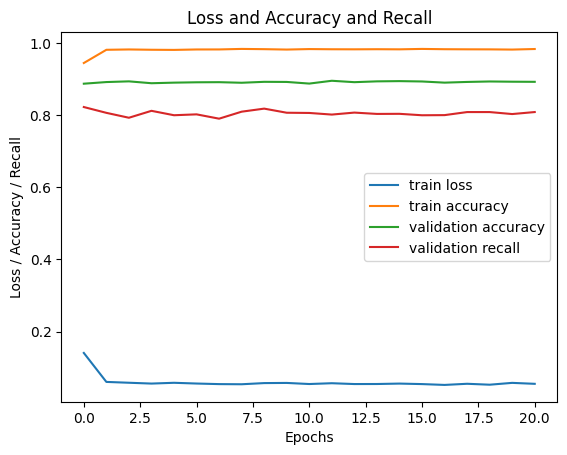

In [12]:
plt.plot(train_loss, label="train loss")
plt.plot(train_accuracy, label="train accuracy")
plt.plot(val_accuracy, label="validation accuracy")
plt.plot(val_recall, label="validation recall")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy / Recall")
plt.title("Loss and Accuracy and Recall")
plt.legend()
plt.show()

In [13]:
model.load_state_dict(torch.load("./save_models/ensemble/ensembled.pt"))

<All keys matched successfully>

100%|██████████| 97/97 [00:21<00:00,  4.59it/s]


[[ 133   16    4    3   12]
 [  10  415    7    5   22]
 [   5    8  365    1  122]
 [   5   20    3   59   13]
 [   7   21   79    2 1752]]
[[0.79166667 0.0952381  0.02380952 0.01785714 0.07142857]
 [0.02178649 0.90413943 0.01525054 0.01089325 0.04793028]
 [0.00998004 0.01596806 0.72854291 0.00199601 0.24351297]
 [0.05       0.2        0.03       0.59       0.13      ]
 [0.00376142 0.01128426 0.0424503  0.00107469 0.94142934]]


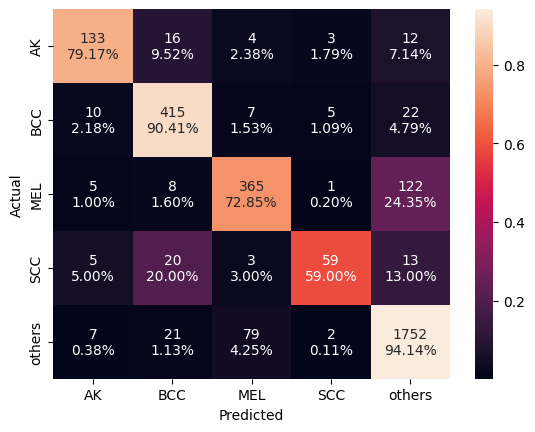

              precision    recall  f1-score   support

           0    0.83125   0.79167   0.81098       168
           1    0.86458   0.90414   0.88392       459
           2    0.79694   0.72854   0.76121       501
           3    0.91202   0.94143   0.92649      1861
           4    0.84286   0.59000   0.69412       100

    accuracy                        0.88184      3089
   macro avg    0.84953   0.79116   0.81534      3089
weighted avg    0.87968   0.88184   0.87956      3089

accuracy: 0.881838782777598
precision: 0.8495317389234938
recall: 0.791155670690908
f1 score: 0.8153431663071421
roc auc score:  0.9621067030777171


In [15]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report


disease_labels = [
    "AK",
    "BCC",
    "MEL",
    "SCC",
    "others"
]


def prediction(model, testloader, device):
    model.eval()
    predictions = []
    predictions_prob = []
    actual = []
    with torch.no_grad():
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            output = torch.nn.functional.softmax(output, dim=1)
            predictions.append(output.max(dim=1)[1])
            actual.append(labels)
            predictions_prob.append(output)

    actual = torch.concat(actual).cpu()
    predictions = torch.concat(predictions).cpu()
    predictions_prob = torch.concat(predictions_prob).cpu()

    return predictions, predictions_prob, actual


# compare predictions with actual labels
# using confusion matrix
def display_confusion_matrix(predictions, labels):
    # convert number labels to disease labels
    # labels = [disease_labels[i] for i in labels]
    # predictions = [disease_labels[i] for i in predictions]
    conf_matrix = confusion_matrix(labels, predictions, labels=[0, 1, 2, 4, 3])
    print(conf_matrix)
    conf_matrix_norm = confusion_matrix(labels, predictions, normalize="true", labels=[0, 1, 2, 4, 3])
    print(conf_matrix_norm)
    
    conf_matrix_comb = [f"{perc:0.0f}\n{num:.2%}" for perc, num in zip(conf_matrix.flatten(), conf_matrix_norm.flatten())]
    conf_matrix_comb = np.asarray(conf_matrix_comb).reshape(5, 5)
    
    sns.heatmap(
        conf_matrix_norm, annot=conf_matrix_comb, fmt="", xticklabels=disease_labels, yticklabels=disease_labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


predictions, predictions_prob, actual = prediction(model, dataloader["test"], device)

display_confusion_matrix(predictions, actual)

print(classification_report(actual, predictions, digits=5))

# sklearn

print(f"accuracy: {metrics.accuracy_score(actual, predictions)}")
print(f"precision: {metrics.precision_score(actual, predictions, average='macro')}")
print(f"recall: {metrics.recall_score(actual, predictions, average='macro')}")
print(f"f1 score: {metrics.f1_score(actual, predictions, average='macro')}")

# roc auc score

roc_auc_score = metrics.roc_auc_score(
    actual, predictions_prob, average="macro", multi_class="ovr"
)
print("roc auc score: ", roc_auc_score)